In [1]:
#required imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('logP_dataset.csv', names=['SMILES', 'logP'])
df.head()

,SMILES,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


In [3]:
from rdkit import Chem 
from rdkit.Chem import PandasTools,Draw

In [4]:
# adding rdkit.Chem.rdchem.Mol object to each molecule to make RDKit based descriptors
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

In [5]:
print(type(df['Molecule'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


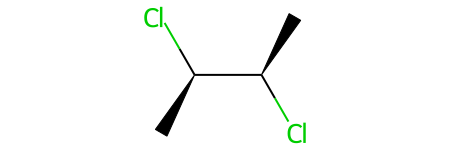

In [6]:
# rdkit.Chem.rdchem.Mol object is auto-rendered when displayed in Jupyter
df['Molecule'][0]

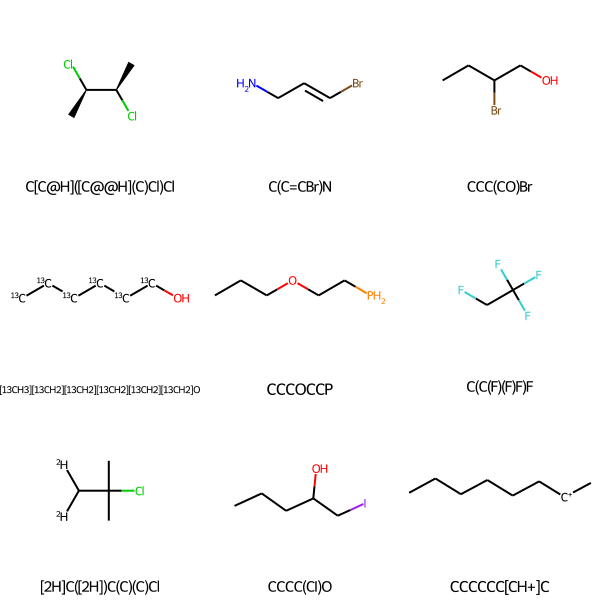

In [7]:
Draw.MolsToGridImage(df['Molecule'][:9], molsPerRow=3, useSVG=True, legends=list(df['SMILES'][:9].values))

In [8]:
# Simple function to get IUPAC names from SMILES to make names more meaninfull using Pubchem DB
import pubchempy


def get_name_from_smiles(smiles):
    compounds = pubchempy.get_compounds(smiles, namespace='smiles')
    match = compounds[0]
    return match.iupac_name

In [9]:
#df['name'] = [get_name_from_smiles(smiles) for smiles in df.SMILES]

BadRequestError: 'PUGREST.BadRequest: error: '

,SMILES,logP,Molecule
0,C[C@H]([C@@H](C)Cl)Cl,2.3,
1,C(C=CBr)N,0.3,
2,CCC(CO)Br,1.3,
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,
4,CCCOCCP,0.6,

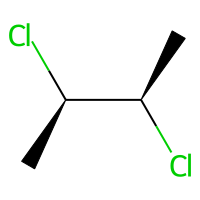
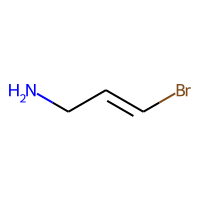
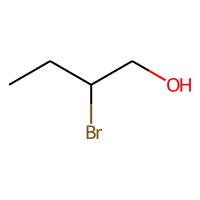
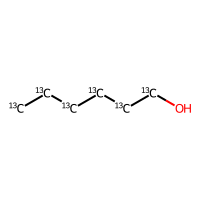
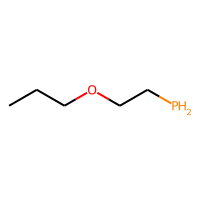

In [10]:
#df.to_csv('logP_dataset_with_names.csv')

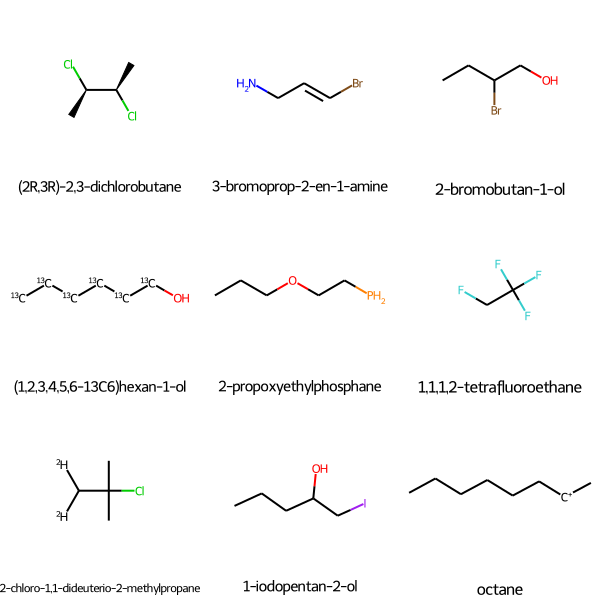

In [11]:
names = [get_name_from_smiles(smiles) for smiles in list(df['SMILES'][:9].values)]

Draw.MolsToGridImage(df['Molecule'][:9], molsPerRow=3, useSVG=True, legends=names)

In [12]:
#geting more info about molecules

df['Molecule'] = df['Molecule'].apply(lambda x: Chem.AddHs(x)) # Hydrogens addition
df['num_of_atoms'] = df['Molecule'].apply(lambda x: x.GetNumAtoms()) # Number of atoms
df['num_of_heavy_atoms'] = df['Molecule'].apply(lambda x: x.GetNumHeavyAtoms()) # Heavy atoms - anu non-H atom

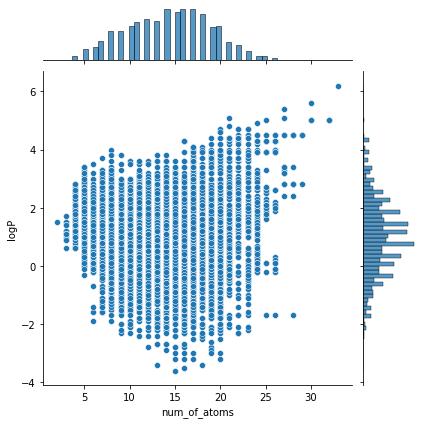

In [13]:
# some visualiasation

import seaborn as sns
sns.jointplot(df.num_of_atoms, df.logP)
plt.show()

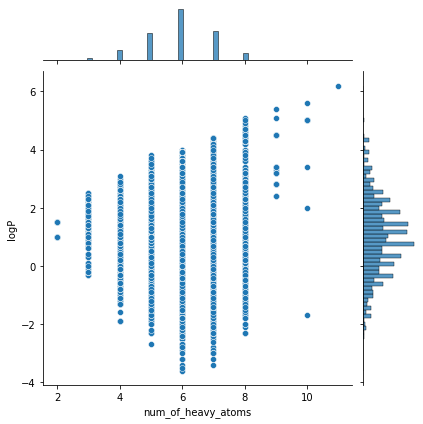

In [14]:
sns.jointplot(df.num_of_heavy_atoms, df.logP)
plt.show()

In [15]:
#searching for patterns such as number of particular atoms will help to make 

#We're going to settle the function that searches patterns and use it for a list of most common atoms only
def number_of_atoms(atoms_list, df):
    for i in atoms_list:
        df['num_of_{}_atoms'.format(i)] = df['Molecule'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

,SMILES,logP,Molecule,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",14,6,4,0,0,2
1,C(C=CBr)N,0.3,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",11,5,3,0,1,0
2,CCC(CO)Br,1.3,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",15,6,4,1,0,0
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",21,7,6,1,0,0
4,CCCOCCP,0.6,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",20,7,5,1,0,0

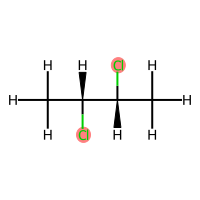
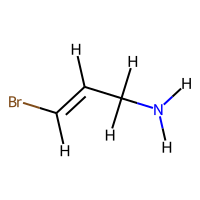
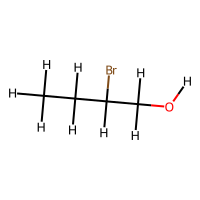
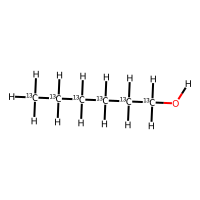
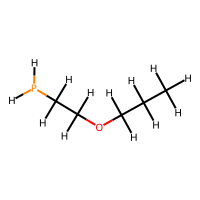

In [16]:
df.head()

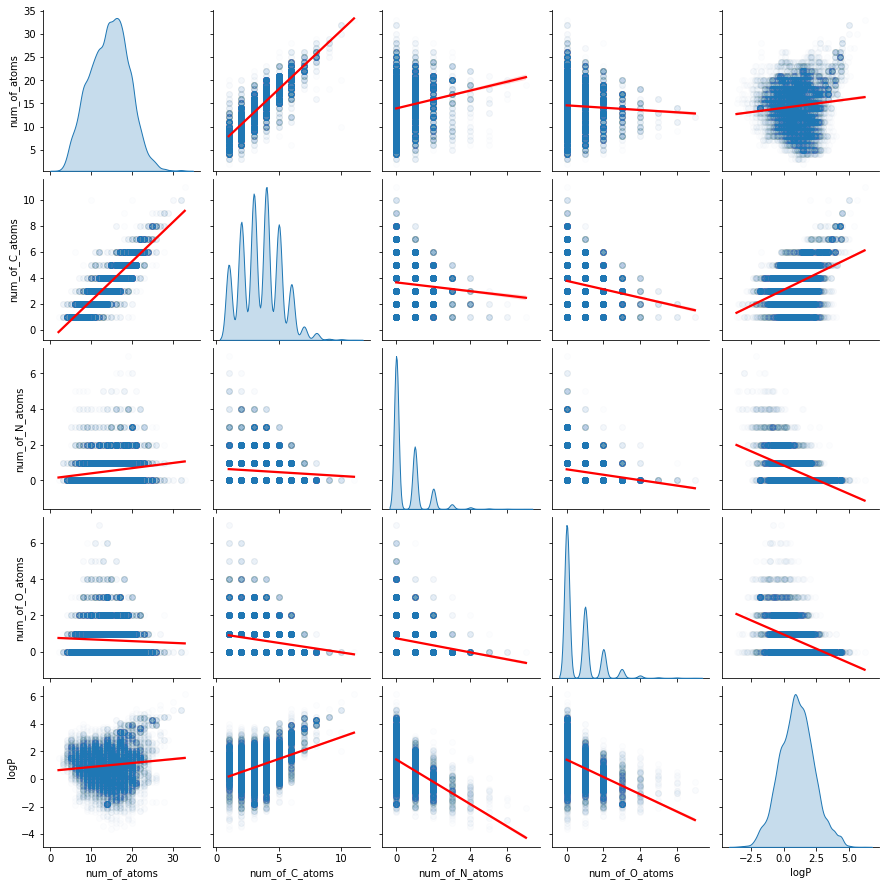

In [17]:
sns.pairplot(df[['num_of_atoms','num_of_C_atoms','num_of_N_atoms', 'num_of_O_atoms', 'logP']], diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.01}})
plt.show()

In [18]:
# first model
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import train_test_split

#Leave only features columns
train_df = df.drop(columns=['SMILES', 'Molecule', 'logP'])
y = df['logP'].values

print(train_df.columns)

#Perform a train-test split. We'll use 10% of the data to evaluate the model while training on 90%

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size = 0.1, random_state=42)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluation(model, X_test, y_test):
    '''
    Evaluaton of fitted model based on mean absolute error and mean squared error
    '''
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    plt.figure(figsize=(15, 10))
    plt.plot(y_pred[:300], "red", label="predicted", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('logP')
    plt.title("MAE {}, MSE {}".format(round(mae, 3), round(mse, 3)))
    plt.show()
    
    print(f'MAE score: {round(mae, 3)}')
    print(f'MSE score: {round(mse,3)}')
    print(f'Coefficient of determination: {round(model.score(X_test, y_test),3)}')
    
def plot_model_coef(model, verbose=False):
    ys = model.coef_
    xs = [x for x  in range(len(ys))]
    
    plt.figure(figsize=(15, 10))
    plt.plot(xs, ys, "red", label="Model", linewidth=1.0)
    plt.xlim(left=0, right=max(xs))
    

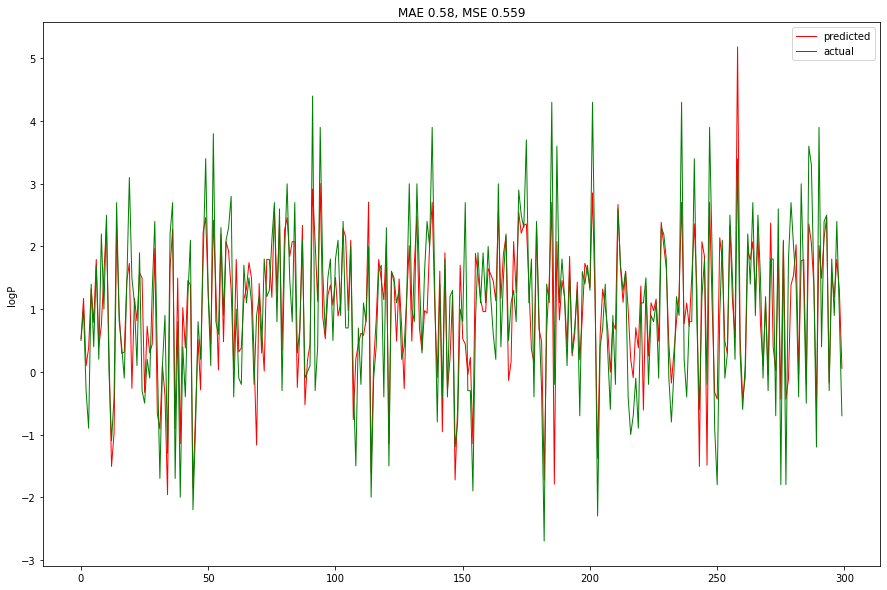

MAE score: 0.58
MSE score: 0.559
Coefficient of determination: 0.682


In [20]:
#Train the model
model_1 = RidgeCV(cv=5)
model_1.fit(X_train, y_train)
#Evaluate results
evaluation(model_1, X_test, y_test)

In [21]:
#impoving model by addding more descriptors
from rdkit.Chem import Descriptors

df['tpsa'] = df['Molecule'].apply(lambda x: Descriptors.TPSA(x))
df['MW'] = df['Molecule'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['Molecule'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['Molecule'].apply(lambda x: Descriptors.NumHeteroatoms(x))

,SMILES,logP,Molecule,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,tpsa,MW,num_valence_electrons,num_heteroatoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",14,6,4,0,0,2,0.00,126.000306,38,2
1,C(C=CBr)N,0.3,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",11,5,3,0,1,0,26.02,134.968361,30,2
2,CCC(CO)Br,1.3,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",15,6,4,1,0,0,20.23,151.983677,38,2
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",21,7,6,1,0,0,20.23,108.124594,44,1
4,CCCOCCP,0.6,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",20,7,5,1,0,0,9.23,120.070402,44,2

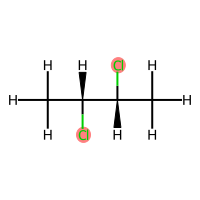
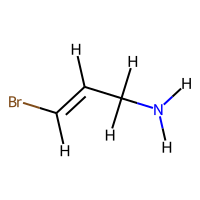
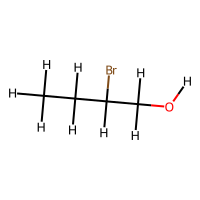
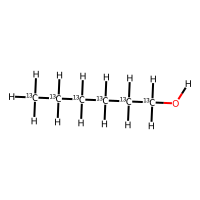
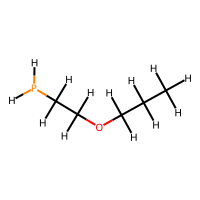

In [22]:
df.head()

In [23]:
# second model

train_df = df.drop(columns=['SMILES', 'Molecule', 'logP'])
y = df['logP'].values

print(train_df.columns)

# same split as for model 1
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=42)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'MW',
       'num_valence_electrons', 'num_heteroatoms'],
      dtype='object')


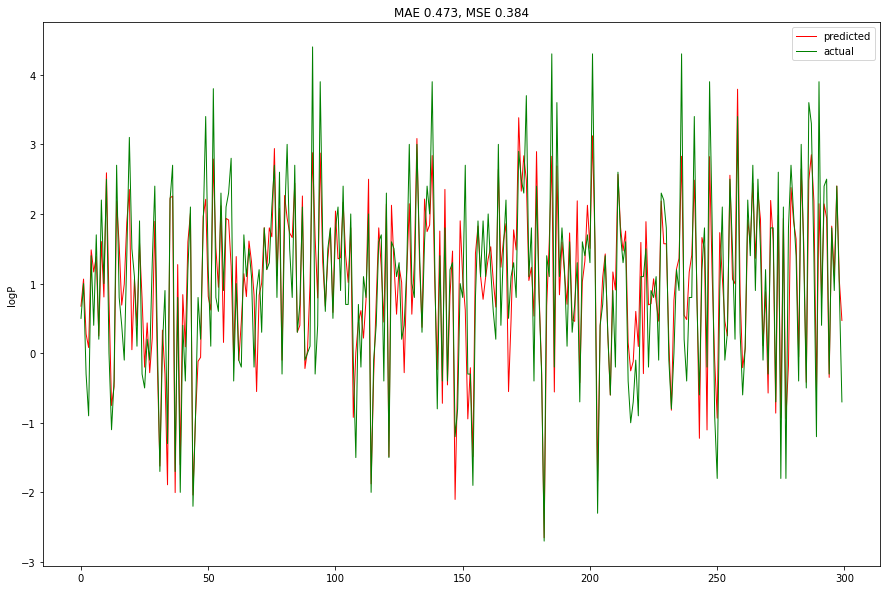

MAE score: 0.473
MSE score: 0.384
Coefficient of determination: 0.781


array([-0.29880467, -0.60802797,  0.15355531, -0.04115535,  0.12141965,
        0.07501113, -0.0336869 ,  0.00497515,  0.27077381, -0.76158328])

In [24]:
model_2 = RidgeCV(cv=5)
model_2.fit(X_train, y_train)
#Evaluate results and plot predictions
evaluation(model_2, X_test, y_test)
display(model_2.coef_)

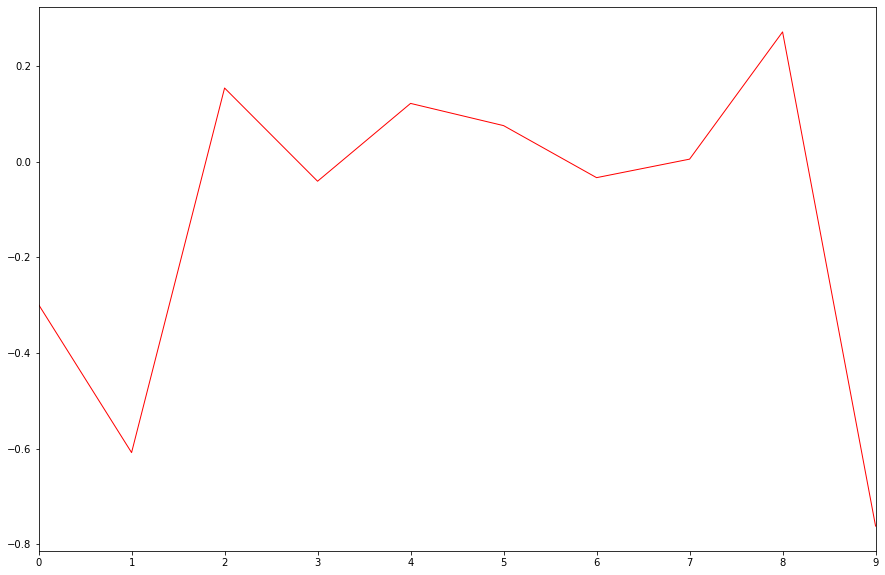

In [25]:
plot_model_coef(model_2)
plt.show()

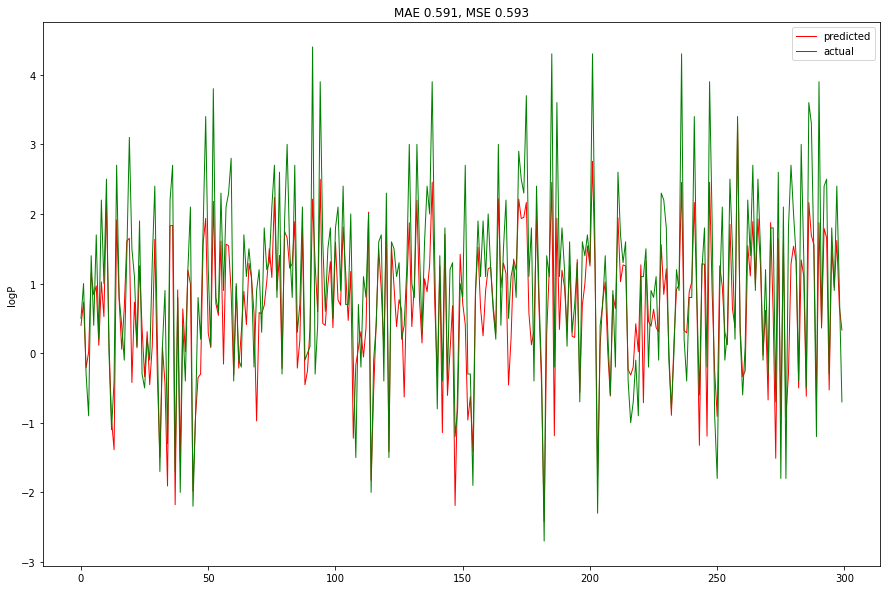

MAE score: 0.591
MSE score: 0.593
Coefficient of determination: 0.663


In [26]:
#model 3
from sklearn.svm import LinearSVR

model_3 = LinearSVR()
model_3.fit(X_train, y_train)
#Evaluate results and plot predictions
evaluation(model_3, X_test, y_test)